<a href="https://colab.research.google.com/github/stanislavfort/exploring_the_limits_of_OOD_detection/blob/main/ViT_for_strong_near_OOD_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
conda create -p $(pwd)/conda_env python=3.9
conda activate conda_env/
pip install jupyter
pip install numpy==1.25.2
pip install -r vision_transformer/vit_jax/requirements.txt
pip uninstall jax jaxlib
pip install -U "jax[cuda11_pip]==0.4.16" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install tensorflow[and-cuda] tf-keras
pip install seaborn
pip install scikit-learn



export PATH="$CONDA_PREFIX/lib/python3.9/site-packages/nvidia/cuda_nvcc/bin:$PATH"
export PYTHONPATH='vmmrdb_datasets'
jupyter-notebook --ip='*'
```

# Replicating the use of ViT for near out-of-distributution detection from
# **Exploring the Limits of Out-of-Distribution Detection** 
by Stanislav Fort, Jie Ren, Balaji Lakshminarayanan

This is Colab performs a key experiments from [Exploring the Limits of Out-of-Distribution Detection](https://arxiv.org/abs/2106.03004), [accepted at NeurIPS 2021](https://proceedings.neurips.cc/paper/2021/hash/3941c4358616274ac2436eacf67fae05-Abstract.html). It uses a large, pretrained and finetuned [Vision Transformer](https://arxiv.org/abs/2010.11929), extracts its embeddings, and performs OOD detection on the hard near-OOD [CIFAR-100 vs CIFAR-10 task](https://paperswithcode.com/sota/out-of-distribution-detection-on-cifar-100-vs). 

This Colab is heavily inspired by the the Google [Colab on using their pretrained and finetuned transformers](https://github.com/google-research/vision_transformer). We modified the `models.py` and load it from our own [repository](https://github.com/stanislavfort/exploring_the_limits_of_OOD_detection) to allow for the extraction of image embeddings from the penultimate layer of the ViT that we use for OOD detection. 

You should expect to run this Colab from top to bottom in around 20 minutes on a single free Colab GPU. It is by default extracting embeddings only for 1/10 of the train and test sets of CIFAR-10 and CIFAR-100 to speed things up. If you want to change that, just set `N_test = 10000` and `N_train = 50000`.

You should expect to see the following plots:

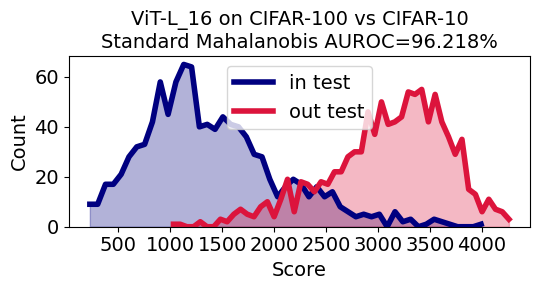

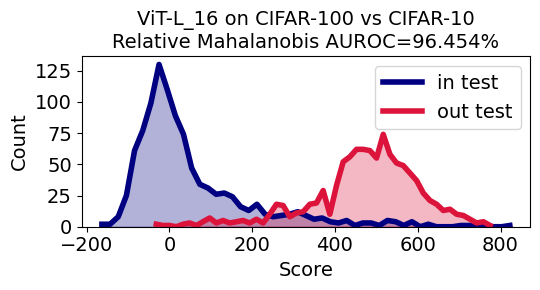

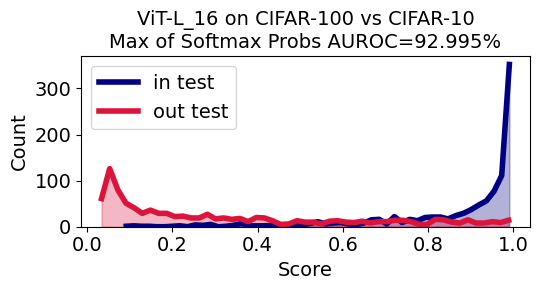

# Imports and loading

In [1]:
import numpy as np

In [2]:
! ptxas --version

ptxas: NVIDIA (R) Ptx optimizing assembler
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:08:00_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [3]:
![ -d vision_transformer ] 
!pwd

/mnt/homeGPU/cpelaez/Collaborations/novelty_detection/sota/TEMP/exploring_the_limits_of_OOD_detection


In [3]:
# Fetch vision_transformer repository.
![ -d vision_transformer ] || git clone https://github.com/google-research/vision_transformer

In [4]:
! cd vision_transformer && git checkout ed1491238f5ff6099cca81087c575a215281ed14

M	vit_jax/models.py
HEAD is now at ed14912 Adds code for "How to train your ViT? ..." paper.


In [5]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

In [4]:
!ls vision_transformer/vit_jax/

checkpoint.py		__init__.py	   models_resnet.py  test_utils.py
checkpoint_test.py	input_pipeline.py  models_test.py    train.py
configs			main.py		   momentum_clip.py  train_test.py
inference_time.py	models_mixer.py    __pycache__	     utils.py
inference_time_test.py	models.py	   requirements.txt


In [6]:
# fetch out repository to get the modified models.py file with the pre-logits extraction
!git clone --depth=1 https://github.com/stanislavfort/exploring_the_limits_of_OOD_detection

Cloning into 'exploring_the_limits_of_OOD_detection'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (9/9), done.


In [7]:
!rm vision_transformer/vit_jax/models.py
!cp exploring_the_limits_of_OOD_detection/models.py vision_transformer/vit_jax/

In [2]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [ ]:
#to add the prelogits versions
from google.colab import files

files.view('vision_transformer/vit_jax/models.py')

In [3]:
!nvidia-smi

Wed Sep 11 10:46:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:B7:00.0 Off |                    0 |
| N/A   37C    P0              51W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


In [5]:
tf.config.list_physical_devices('GPU')

2024-09-11 10:46:52.922253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib
2024-09-11 10:46:52.922297: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Loading ViT checkpoints from Google Brain repo

### Load a checkpoint

In [7]:
#selecting a ViT checkpoint
filename = 'L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

1159.0 MiB - gs://vit_models/augreg/L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384.npz


2024-09-11 10:47:07.464915: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [8]:
tf.io.gfile.stat(path)

In [9]:
ds, ds_info = tfds.load(tfds_name, with_info=True,batch_size=128)
ds_info

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/home/cpelaez/tensorflow_datasets/cifar100/3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disa

In [10]:
model_config

classifier: token
hidden_size: 1024
name: ViT-L_16
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 4096
  num_heads: 16
  num_layers: 24

In [11]:
# Get a clean model
model = models.VisionTransformer(
    num_classes=ds_info.features['label'].num_classes, **model_config)

In [12]:
# Load a checkpoint from cloud
# takes a while for a big model
# params = checkpoint.load(path)
params = checkpoint.load('./ViT-L_16_vmmrdb_brand_665.npz')

In [13]:
# out modified model that outputs pre-logits = embeddings for OOD detection
model_prelogits = models.VisionTransformer_prelogits(
    num_classes=ds_info.features['label'].num_classes, **model_config)

# Getting unaugmented datasets

In [14]:
def pp(img, sz):
  img = tf.cast(img, float) / 255.0
  img = tf.image.resize(img, [sz, sz])
  return img

In [15]:
import tensorflow_datasets as tfds 
import tensorflow as tf

def prepare_pure_dataset(ds_in, num_classes,repeats = 1,shuffle=True, batch_size=128):

  ds_in = ds_in.map(lambda d: {"image": pp(d["image"],resolution), "label": d["label"]}, tf.data.experimental.AUTOTUNE)

  ds_in = ds_in.repeat(repeats)
  if shuffle:
    ds_in = ds_in.shuffle(200000)

  ds_in = ds_in.batch(batch_size, drop_remainder=True)

  return ds_in

In [20]:
batch_size = 128

cifar10_ds_train = prepare_pure_dataset(tfds.load('cifar10', split='train', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar10_ds_test = prepare_pure_dataset(tfds.load('cifar10', split='test', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar100_ds_train = prepare_pure_dataset(tfds.load('cifar100', split='train', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)
cifar100_ds_test = prepare_pure_dataset(tfds.load('cifar100', split='test', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)

In [21]:
cifar10_ds_train

<BatchDataset shapes: {image: (128, 384, 384, 3), label: (128,)}, types: {image: tf.float32, label: tf.int64}>

In [22]:
#verification
def get_value_spreads_for_dataset(ds_in):
  batch = next(ds_in.as_numpy_iterator())
  images = batch["image"]
  min_now,mean_now,max_now = np.min(images),np.mean(images),np.max(images)
  return min_now,mean_now,max_now

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_test)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_test)
print(min_now,mean_now,max_now)


2024-09-11 08:03:42.355055: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-11 08:03:42.551305: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0 0.47670496 1.0
0.0 0.4786665 1.0


2024-09-11 08:03:42.764706: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-11 08:03:42.964596: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0 0.5022136 1.0
0.0 0.47278368 1.0


# Prelogits extraction

## Extractor

In [23]:
import time

def standalone_get_prelogits(params, ds_in,image_count=50000):
  """Returns prelogits on the dataset"""
  prelogits_all = []
  logits_all = []
  labels_all = []

  ts = []

  t1 = time.time()

  for batch in ds_in.as_numpy_iterator():

    prelogits = model_prelogits.apply({'params': params}, batch["image"], train=False)
    logits = model.apply({'params': params}, batch["image"], train=False)

    prelogits_all.append(prelogits)
    logits_all.append(logits)
    labels_all.append(batch["label"])

    count_so_far = len(np.concatenate(prelogits_all,axis=0))

    t2 = time.time()
    ts.append(t2-t1)
    t1 = time.time()

    t_rem = (image_count-count_so_far)*np.mean(ts)/batch_size

    print("Images done="+str(count_so_far)+" time remaining="+str(int(t_rem))+"s")

    if count_so_far >= image_count:
      break #early break for subsets of data

  return np.concatenate(prelogits_all,axis=0), np.concatenate(logits_all,axis=0), np.concatenate(labels_all,axis=0)

## Getting the prelogits

The full datasets extraction will take some time. Taking a 1/10 subset is sufficient to show the effectivness of the Mahalanobis distance and Relative Mahalanobis distance as compared to the Maximum over Softmax Probabilities and runs in 20 mins on a single V100 GPU in a Colab (probably slower on a P100).

In [24]:
# choosing the subsets of the train and test set to extract embeddings for
N_train = 5000
N_test = 1000

assert N_train <= 50000
assert N_test <= 10000

### CIFAR-10 test (1.5 minutes)

In [25]:
cifar10_test_prelogits, cifar10_test_logits, cifar10_test_labels = standalone_get_prelogits(
    params, 
    cifar10_ds_test, 
    image_count=N_test
    )

Images done=128 time remaining=147s
Images done=256 time remaining=82s
Images done=384 time remaining=56s
Images done=512 time remaining=39s
Images done=640 time remaining=27s
Images done=768 time remaining=16s
Images done=896 time remaining=7s
Images done=1024 time remaining=-1s


2024-09-11 08:05:00.212452: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### CIFAR-100 test (1.5 minutes)

In [26]:
cifar100_test_prelogits, cifar100_test_logits, cifar100_test_labels = standalone_get_prelogits(
    params, 
    cifar100_ds_test, 
    image_count=N_test
    )

Images done=128 time remaining=44s
Images done=256 time remaining=38s
Images done=384 time remaining=31s
Images done=512 time remaining=25s
Images done=640 time remaining=18s
Images done=768 time remaining=12s
Images done=896 time remaining=5s
Images done=1024 time remaining=-1s


2024-09-11 08:05:54.126451: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### CIFAR-10 train (8 minutes)

In [27]:
cifar10_train_prelogits, cifar10_train_logits, cifar10_train_labels = standalone_get_prelogits(
    params, 
    cifar10_ds_train, 
    image_count=N_train
    )

Images done=128 time remaining=253s
Images done=256 time remaining=250s
Images done=384 time remaining=241s
Images done=512 time remaining=235s
Images done=640 time remaining=227s
Images done=768 time remaining=221s
Images done=896 time remaining=213s
Images done=1024 time remaining=207s
Images done=1152 time remaining=201s
Images done=1280 time remaining=194s
Images done=1408 time remaining=187s
Images done=1536 time remaining=181s
Images done=1664 time remaining=174s
Images done=1792 time remaining=168s
Images done=1920 time remaining=161s
Images done=2048 time remaining=155s
Images done=2176 time remaining=148s
Images done=2304 time remaining=141s
Images done=2432 time remaining=135s
Images done=2560 time remaining=128s
Images done=2688 time remaining=121s
Images done=2816 time remaining=114s
Images done=2944 time remaining=107s
Images done=3072 time remaining=101s
Images done=3200 time remaining=94s
Images done=3328 time remaining=87s
Images done=3456 time remaining=81s
Images done

2024-09-11 08:10:23.274909: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### CIFAR-100 train (8 minutes)

In [28]:
cifar100_train_prelogits, cifar100_train_logits, cifar100_train_labels = standalone_get_prelogits(
    params, 
    cifar100_ds_train, 
    image_count=N_train
    )

Images done=128 time remaining=267s
Images done=256 time remaining=256s
Images done=384 time remaining=244s
Images done=512 time remaining=238s
Images done=640 time remaining=229s
Images done=768 time remaining=223s
Images done=896 time remaining=216s
Images done=1024 time remaining=209s
Images done=1152 time remaining=202s
Images done=1280 time remaining=196s
Images done=1408 time remaining=188s
Images done=1536 time remaining=181s
Images done=1664 time remaining=175s
Images done=1792 time remaining=169s
Images done=1920 time remaining=162s
Images done=2048 time remaining=155s
Images done=2176 time remaining=148s
Images done=2304 time remaining=142s
Images done=2432 time remaining=135s
Images done=2560 time remaining=128s
Images done=2688 time remaining=121s
Images done=2816 time remaining=115s
Images done=2944 time remaining=108s
Images done=3072 time remaining=101s
Images done=3200 time remaining=94s
Images done=3328 time remaining=87s
Images done=3456 time remaining=81s
Images done

2024-09-11 08:14:52.846637: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Accuracies

In [29]:
# checking the accuracy on CIFAR-100

finetune_test_acc = np.mean(
    np.argmax(cifar100_test_logits,axis=-1) == cifar100_test_labels
    )

print("CIFAR-100 test accuracy = "+str(finetune_test_acc))

finetune_train_acc = np.mean(
    np.argmax(cifar100_train_logits,axis=-1) == cifar100_train_labels
    )

print("CIFAR-100 train accuracy = "+str(finetune_train_acc))

CIFAR-100 test accuracy = 0.943359375
CIFAR-100 train accuracy = 0.9728515625


# Computing near-OOD AUROC

In [30]:
cifar10_test_embeds = cifar10_test_prelogits
cifar10_y_test = cifar10_test_labels
cifar10_test_preds = cifar10_test_logits

cifar100_test_embeds = cifar100_test_prelogits
cifar100_y_test = cifar100_test_labels
cifar100_test_preds = cifar100_test_logits

cifar10_train_embeds = cifar10_train_prelogits
cifar10_y_train = cifar10_train_labels
cifar10_train_preds = cifar10_train_logits

cifar100_train_embeds = cifar100_train_prelogits
cifar100_y_train = cifar100_train_labels
cifar100_train_preds = cifar100_train_logits

## Computing Mahalanobis means and covariances

In [31]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

In [32]:
from sklearn.metrics import roc_auc_score

def maha_distance(xs,cov_inv_in,mean_in,norm_type=None):
  diffs = xs - mean_in.reshape([1,-1])

  second_powers = np.matmul(diffs,cov_inv_in)*diffs

  if norm_type in [None,"L2"]:
    return np.sum(second_powers,axis=1)
  elif norm_type in ["L1"]:
    return np.sum(np.sqrt(np.abs(second_powers)),axis=1)
  elif norm_type in ["Linfty"]:
    return np.max(second_powers,axis=1)

def get_scores(
    indist_train_embeds_in,
    indist_train_labels_in,
    indist_test_embeds_in,
    outdist_test_embeds_in,
    subtract_mean = True,
    normalize_to_unity = True,
    subtract_train_distance = True,
    indist_classes = 100,
    norm_name = "L2",
    ):
  
  # storing the replication results
  maha_intermediate_dict = dict()
  
  description = ""
  
  all_train_mean = np.mean(indist_train_embeds_in,axis=0,keepdims=True)

  indist_train_embeds_in_touse = indist_train_embeds_in
  indist_test_embeds_in_touse = indist_test_embeds_in
  outdist_test_embeds_in_touse = outdist_test_embeds_in

  if subtract_mean:
    indist_train_embeds_in_touse -= all_train_mean
    indist_test_embeds_in_touse -= all_train_mean
    outdist_test_embeds_in_touse -= all_train_mean
    description = description+" subtract mean,"

  if normalize_to_unity:
    indist_train_embeds_in_touse = indist_train_embeds_in_touse / np.linalg.norm(indist_train_embeds_in_touse,axis=1,keepdims=True)
    indist_test_embeds_in_touse = indist_test_embeds_in_touse / np.linalg.norm(indist_test_embeds_in_touse,axis=1,keepdims=True)
    outdist_test_embeds_in_touse = outdist_test_embeds_in_touse / np.linalg.norm(outdist_test_embeds_in_touse,axis=1,keepdims=True)
    description = description+" unit norm,"

  #full train single fit
  mean = np.mean(indist_train_embeds_in_touse,axis=0)
  cov = np.cov((indist_train_embeds_in_touse-(mean.reshape([1,-1]))).T)

  eps = 1e-8
  cov_inv = np.linalg.inv(cov)

  #getting per class means and covariances
  class_means = []
  class_cov_invs = []
  class_covs = []
  for c in range(indist_classes):

    mean_now = np.mean(indist_train_embeds_in_touse[indist_train_labels_in == c],axis=0)

    cov_now = np.cov((indist_train_embeds_in_touse[indist_train_labels_in == c]-(mean_now.reshape([1,-1]))).T)
    class_covs.append(cov_now)
    # print(c)

    eps = 1e-8
    cov_inv_now = np.linalg.inv(cov_now)

    class_cov_invs.append(cov_inv_now)
    class_means.append(mean_now)

  #the average covariance for class specific
  class_cov_invs = [np.linalg.inv(np.mean(np.stack(class_covs,axis=0),axis=0))]*len(class_covs)

  maha_intermediate_dict["class_cov_invs"] = class_cov_invs
  maha_intermediate_dict["class_means"] = class_means
  maha_intermediate_dict["cov_inv"] = cov_inv
  maha_intermediate_dict["mean"] = mean

  out_totrain = maha_distance(outdist_test_embeds_in_touse,cov_inv,mean,norm_name)
  in_totrain = maha_distance(indist_test_embeds_in_touse,cov_inv,mean,norm_name)

  out_totrainclasses = [maha_distance(outdist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
  in_totrainclasses = [maha_distance(indist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]

  out_scores = np.min(np.stack(out_totrainclasses,axis=0),axis=0)
  in_scores = np.min(np.stack(in_totrainclasses,axis=0),axis=0)

  if subtract_train_distance:
    out_scores = out_scores - out_totrain
    in_scores = in_scores - in_totrain


  onehots = np.array([1]*len(out_scores) + [0]*len(in_scores))
  scores = np.concatenate([out_scores,in_scores],axis=0)

  return onehots, scores, description, maha_intermediate_dict

In [33]:
from sklearn.metrics import roc_auc_score

def get_auroc(onehots,scores,make_plot = True,add_to_title=None,swap_classes=False):

  auroc = roc_auc_score(onehots, scores)

  to_replot_dict = dict()

  if swap_classes == False:
    out_scores,in_scores = scores[onehots==0], scores[onehots==1] 
  else:
    out_scores,in_scores = scores[onehots==1], scores[onehots==0] 

  if make_plot:
    plt.figure(figsize = (5.5,3),dpi=100)

    if add_to_title is not None:
      plt.title(add_to_title+" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)
    else:
      plt.title(" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)


  vals,bins = np.histogram(out_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="in test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

  to_replot_dict["out_bin_centers"] = bin_centers
  to_replot_dict["out_vals"] = vals

  vals,bins = np.histogram(in_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="out test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

  to_replot_dict["in_bin_centers"] = bin_centers
  to_replot_dict["in_vals"] = vals

  if make_plot:
    plt.xlabel("Score",fontsize=14)
    plt.ylabel("Count",fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim([0,None])

    plt.legend(fontsize = 14)

    plt.tight_layout()
    plt.show()

  return auroc,to_replot_dict

## Standard Mahalanobis distance

In [34]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )


In [35]:
class_means = maha_intermediate_dict["class_means"]
class_cov_invs = maha_intermediate_dict["class_cov_invs"]

indist_test_embeds = cifar100_test_embeds

outdist_test_embeds = cifar10_test_embeds

indist_dists = []
for c in range(100):
  indist_offset_now = indist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(indist_offset_now,class_cov_invs[c])*indist_offset_now,axis=1)
  indist_dists.append(maha_dists_now)

outdist_dists = []
for c in range(100):
  outdist_offset_now = outdist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(outdist_offset_now,class_cov_invs[c])*outdist_offset_now,axis=1)
  outdist_dists.append(maha_dists_now)



In [36]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [37]:
print("CIFAR-100 score = "+str(np.mean(indist_min))+"+-"+str(np.std(indist_min)))
print("CIFAR-10 score = "+str(np.mean(outdist_min))+"+-"+str(np.std(outdist_min)))

CIFAR-100 score = 1391.4045755681304+-649.6088296006599
CIFAR-10 score = 3097.3705057547327+-569.7103948293093


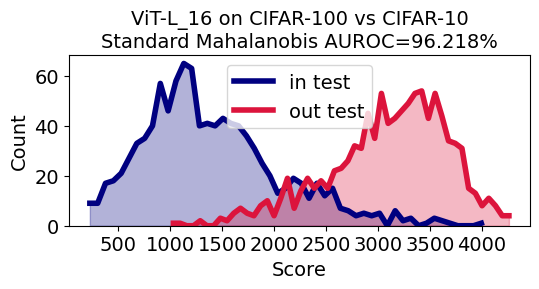

In [38]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

## Relative Mahalanobis distance

In [39]:
train_mean = maha_intermediate_dict["mean"]
train_cov_inv = maha_intermediate_dict["cov_inv"]

In [40]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = True,
    )



In [41]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [42]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

prelogits = indist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
indist_train_dist = train_maha_dist

prelogits = outdist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
outdist_train_dist = train_maha_dist

outdist_scores = outdist_min-outdist_train_dist
indist_scores = indist_min-indist_train_dist

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_scores,indist_scores],axis=0)

In [43]:
print("CIFAR-100 score = "+str(np.mean(indist_scores))+"+-"+str(np.std(indist_scores)))
print("CIFAR-10 score = "+str(np.mean(outdist_scores))+"+-"+str(np.std(outdist_scores)))

CIFAR-100 score = 51.78966381695031+-140.95521952403465
CIFAR-10 score = 477.5608991452434+-131.572644263848


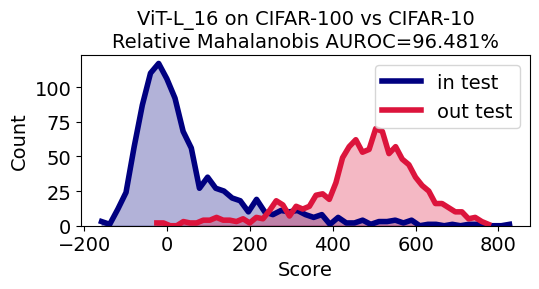

In [44]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nRelative Mahalanobis"
    )

## Max of Softmax Probabilities score

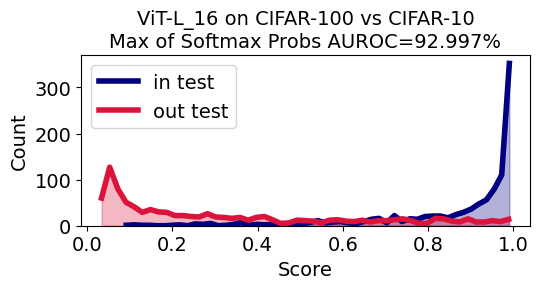

In [45]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(cifar100_test_logits),axis=-1),
     np.max(np_softmax(cifar10_test_logits),axis=-1),
    ],axis=0)
)

onehots = np.array(
    [1]*len(cifar100_test_logits)+[0]*len(cifar10_test_logits)
)

auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nMax of Softmax Probs",
    swap_classes=True,
    )